In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.style.use('seaborn')
import pandas_profiling
import seaborn as sns
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Path shortcut to files
path = '/content/drive/My Drive/GITHUB REPO/Walmart_forecasting_ML'

In [4]:
features = pd.read_csv(f"{path}/walmart_data/features.csv")
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
stores = pd.read_csv(f"{path}/walmart_data/stores.csv")
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [6]:
main_set = pd.read_csv(f"{path}/walmart_data/train.csv")
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
print("Features set:",len(features))
print("Stores set:",len(stores))
print("Main set:", len(main_set))

Features set: 8190
Stores set: 45
Main set: 421570


In [8]:
# The final testing set
pd.read_csv(f"{path}/walmart_data/test.csv").head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


We have to merge with 'stores and features' data frames to get more attributes

### **Merging the full dataset (main_set)**

In [9]:
# merge with stores dataframe
main_set = main_set.merge(stores, how='left', on='Store')
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [10]:
# merge with features dataframe
main_set = main_set.merge(features, how='left')
main_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


### **Split train/test data**

* train set > 2010-02-05 to 2011-12-31
* test_set > 2012-01-01 to 2012-11-01

In [11]:
train_set = main_set[main_set['Date']<='2011-12-31']
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [12]:
test_set = main_set[main_set['Date']>'2011-12-31']
test_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
100,1,1,2012-01-06,16567.69,False,A,151315,49.01,3.157,6277.39,21813.16,143.10,1450.13,8483.00,219.714258,7.348
101,1,1,2012-01-13,16894.40,False,A,151315,48.53,3.261,5183.29,8025.87,42.24,453.08,3719.38,219.892526,7.348
102,1,1,2012-01-20,18365.10,False,A,151315,54.11,3.268,4139.87,2807.19,33.88,500.62,3400.21,219.985689,7.348
103,1,1,2012-01-27,18378.16,False,A,151315,54.26,3.290,1164.46,1082.74,44.00,11.00,1222.19,220.078852,7.348
104,1,1,2012-02-03,23510.49,False,A,151315,56.55,3.360,34577.06,3579.21,160.53,32403.87,5630.40,220.172015,7.348


train/test ratio: ~70/30

In [13]:
print("Train Ratio Set:", f"{round((len(train_set) / len(main_set) * 100), 4)}%")
print("Test Ratio Set:", f"{round((len(test_set) / len(main_set) * 100), 4)}%")

Train Ratio Set: 69.7706%
Test Ratio Set: 30.2294%


## **Exploratory Data Analysis**

We have to decide how correlate are the attributes and how they affect the target value. Furthermore, we have to decide wich attributes to use in the model and the ones we should drop.

In [14]:
# Get a report of actual train set
# train_report = pandas_profiling.ProfileReport(train_set)
# train_report.to_file(outputfile=f"{path}/trainSet_report.html")

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


<div class="col-md-12" style="padding-left: 1em;">
	<p class="h4">Warnings</p>
	<ul class="list-unstyled">
		<li>
			<a href="#pp_var_Date">
				<code>Date</code>
			</a> has a high cardinality: 100 distinct values  
			<span class="label label-warning">Warning</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown1">
				<code>MarkDown1</code>
			</a> has 270432 / 91.9% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown2">
				<code>MarkDown2</code>
			</a> has 273978 / 93.1% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown3">
				<code>MarkDown3</code>
			</a> has 271016 / 92.1% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown4">
				<code>MarkDown4</code>
			</a> has 273090 / 92.8% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_MarkDown5">
				<code>MarkDown5</code>
			</a> has 270138 / 91.8% missing values 
			<span class="label label-default">Missing</span>
		</li>
		<li>
			<a href="#pp_var_Store">
				<code>Store</code>
			</a> is highly correlated with 
			<a href="#pp_var_index">
				<code>index</code>
			</a> (ρ = 0.9992) 
			<span class="label label-primary">Rejected</span>
		</li>
	</ul>
</div>

**About report Warnings**

* Date: Not droppable

* MarkDown: Since the missing values are in range (91.8% - 93.1%) we could drop those attributes. But this MarkDowns are data relational about promotions in diferents stores. So we will fill missing data with 0 insted.

* Store: The number of the store, is a categorical value

In [15]:
# Correlation
train_set.corr()["Weekly_Sales"].sort_values(ascending=False)

Weekly_Sales    1.000000
Size            0.242578
Dept            0.141572
MarkDown3       0.096027
MarkDown5       0.061857
MarkDown1       0.046927
MarkDown4       0.018197
IsHoliday       0.013798
Fuel_Price      0.004089
MarkDown2      -0.006026
Temperature    -0.007814
CPI            -0.021635
Unemployment   -0.025659
Store          -0.084339
Name: Weekly_Sales, dtype: float64

#### **Store**

The store number

In [16]:
train_set[['Store', 'Weekly_Sales']].corr()['Weekly_Sales']

Store          -0.084339
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

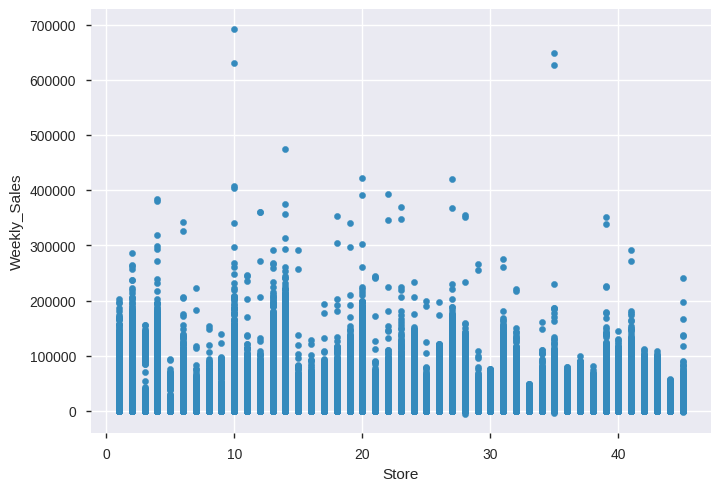

In [17]:
train_set.plot(kind='scatter', x='Store', y='Weekly_Sales')

In [18]:
# 45 differents stores
np.unique(train_set["Store"].unique(), return_counts=True)[1].sum()

45

Text(0, 0.5, 'Total Sales')

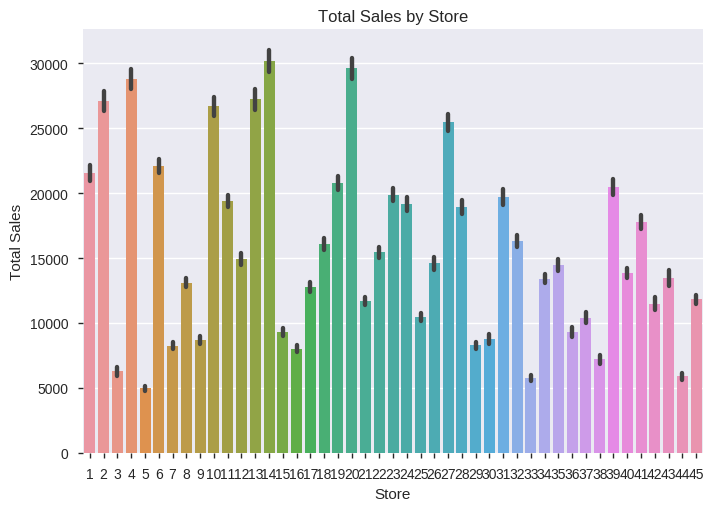

In [19]:
ax = sns.barplot(data=train_set, x="Store", y="Weekly_Sales")
ax.set_title("Total Sales by Store")
ax.set_ylabel("Total Sales")

#### **Dept**

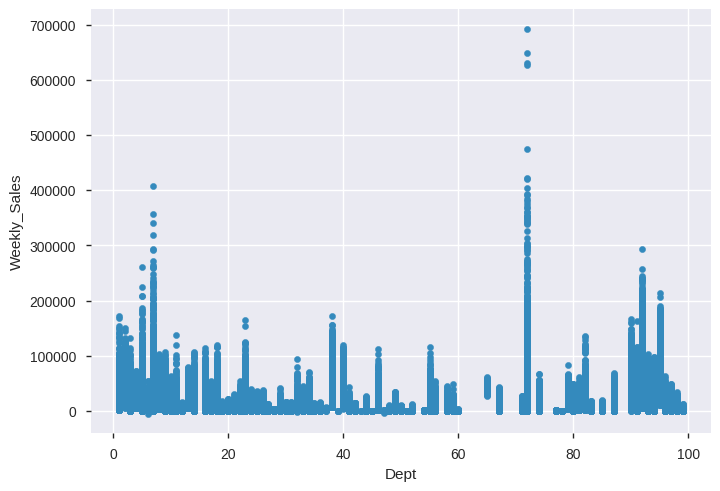

In [20]:
# Scatter plot
train_set.plot(kind='scatter', x='Dept', y='Weekly_Sales')

In [80]:
# Correlation with weekly sales
train_set[['Dept', 'Weekly_Sales']].corr()['Weekly_Sales']

Dept            0.141572
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

#### **Date**

So, the week in the year is correlated with the target attribute. It has a pattern.

<Figure size 500x200 with 0 Axes>

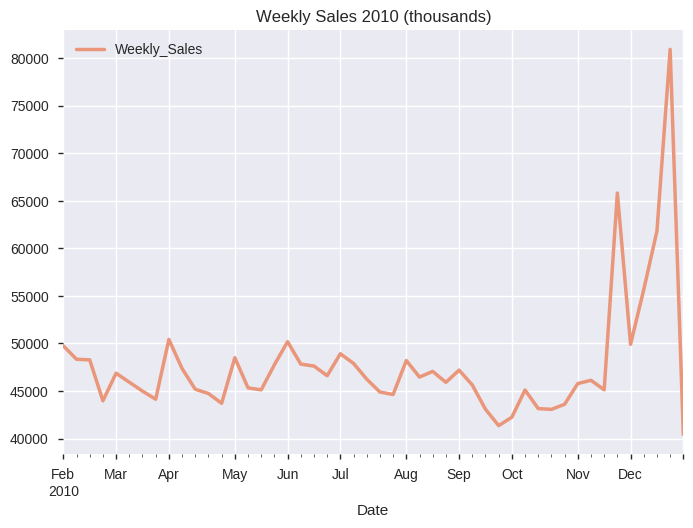

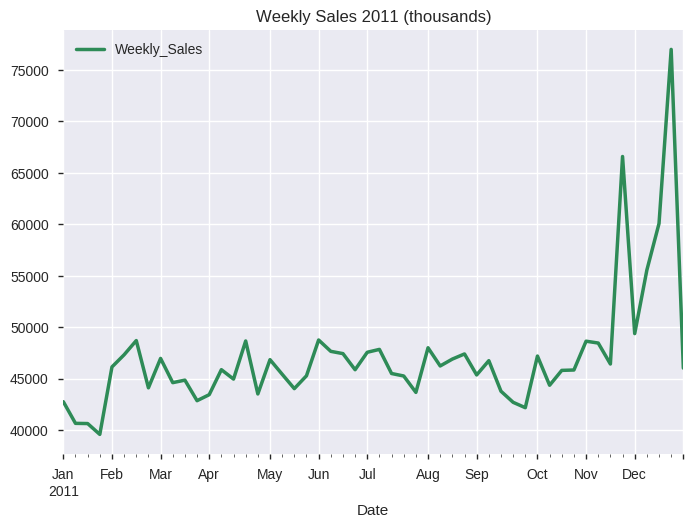

In [21]:
data = train_set[["Date", "Weekly_Sales"]].groupby(by=["Date"]).sum().reset_index()
data["Date"] = pd.to_datetime(data["Date"])
data["Weekly_Sales"] = data['Weekly_Sales'] / 1000

data_2010 = data[data['Date']<"2011"]
data_2011 = data[data["Date"] >= "2011"]
fig = plt.figure(figsize=(5, 2))
data_2010.plot(x='Date', y="Weekly_Sales", kind="line",\
               color="darksalmon", linewidth=2.5, title="Weekly Sales 2010 (thousands)")
data_2011.plot(x='Date', y="Weekly_Sales", kind="line", \
               color="seagreen", linewidth=2.5, title="Weekly Sales 2011 (thousands)")

#### **IsHoliday**

Whether the week is a special holiday week

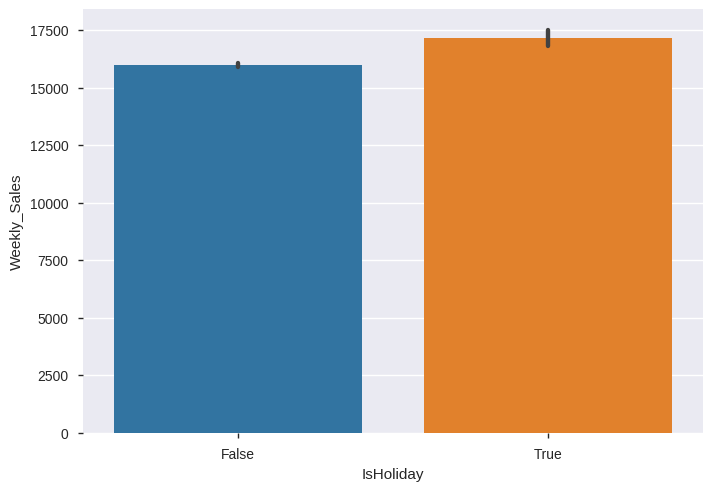

In [22]:
sns.barplot(data=train_set, x='IsHoliday', y='Weekly_Sales')

In [39]:
# Mean Sales whether is holiday or not
holiday = train_set[['IsHoliday', 'Weekly_Sales']].groupby(by='IsHoliday').mean()
total = holiday['Weekly_Sales'].sum()
holiday['percent'] = round(holiday['Weekly_Sales'	] / total, 4)*100
holiday

,Weekly_Sales,percent
IsHoliday,,
False,16011.529605,48.25
True,17175.659843,51.75


#### **Type**

Type of store
**A, B and C**

In [24]:
# Types of store: A, B and C
train_set['Type'].unique()

array(['A', 'B', 'C'], dtype=object)

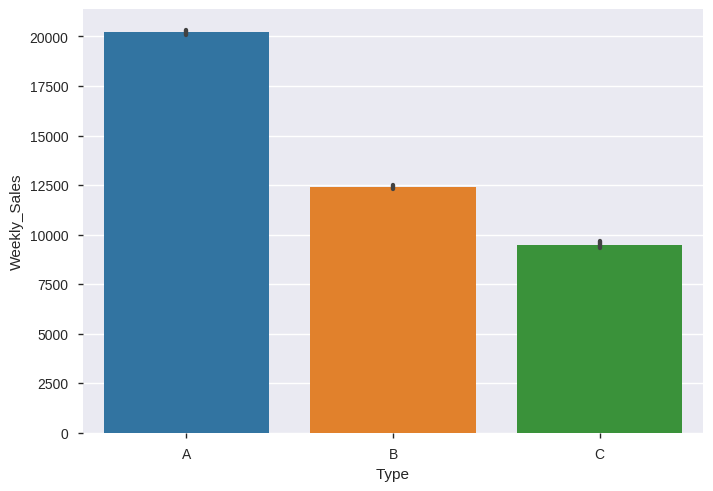

In [25]:
sns.barplot(data=train_set[['Type', 'Weekly_Sales']], x='Type', y='Weekly_Sales')

So, the type of the store is correlated with the mean of weekly sales.

In [26]:
# Mean sales between type of stores
type_store = train_set[['Type', 'Weekly_Sales']].groupby(by='Type').mean()
total = type_store['Weekly_Sales'].sum()
type_store['percent'] = round(type_store['Weekly_Sales'	] / total, 4) * 100
type_store

,Weekly_Sales,percent
Type,,
A,20214.779854,0.4803
B,12392.616971,0.2944
C,9482.706873,0.2253


(0, 80000)

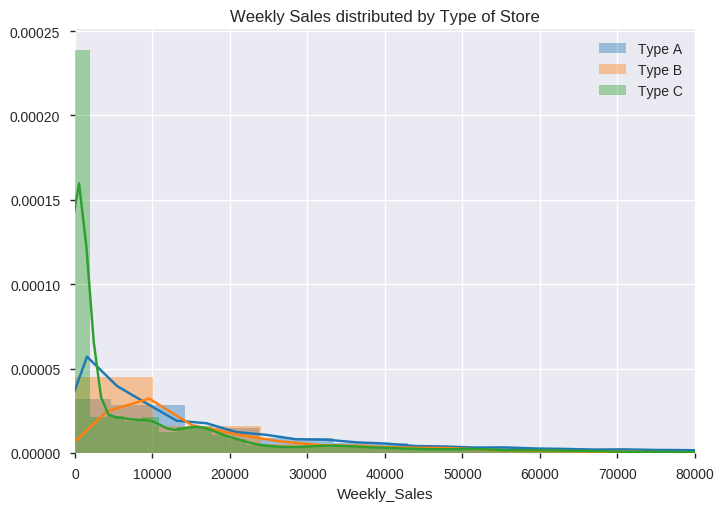

In [60]:
a_data = train_set[train_set['Type']=='A']
b_data = train_set[train_set['Type']=='B']
c_data = train_set[train_set['Type']=='C']

fig, ax = plt.subplots(1, 1)
sns.distplot(a_data['Weekly_Sales'], label='Type A')
sns.distplot(b_data['Weekly_Sales'], label='Type B')
sns.distplot(c_data['Weekly_Sales'], label='Type C')
ax.legend()
ax.set_title("Weekly Sales distributed by Type of Store")
ax.set_xlim(0, 80000)

#### **Size**

Store's size

In [27]:
train_set[['Size', 'Weekly_Sales']].corr()['Weekly_Sales']

Size            0.242578
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

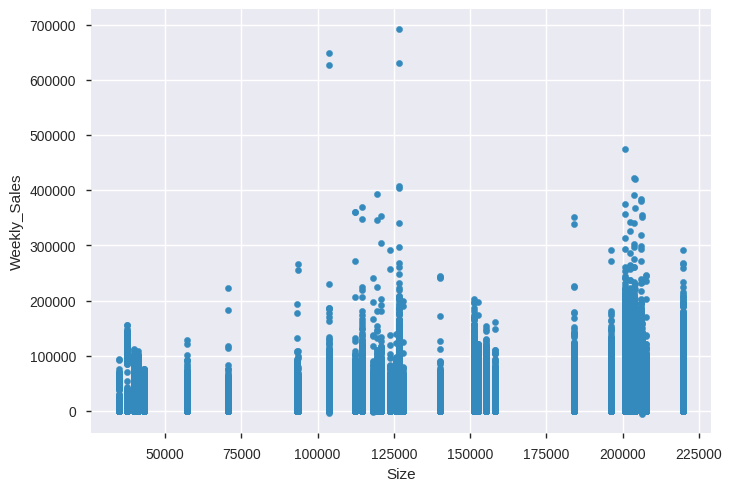

In [28]:
train_set.plot(kind='scatter', x='Size', y='Weekly_Sales')

In [29]:
print('Unique values in Size:')
train_set['Size'].nunique()

Unique values in Size:


40

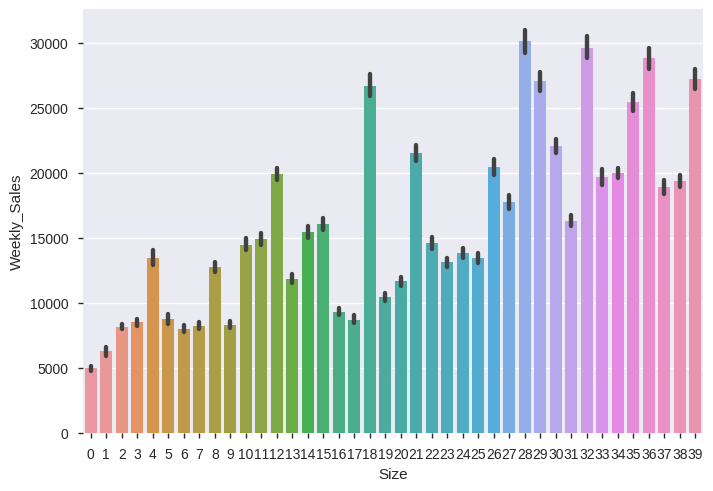

In [30]:
temp_set = train_set[['Size', 'Weekly_Sales']].copy()
ax = sns.barplot(data=temp_set, x='Size', y='Weekly_Sales')
ax.set_xticklabels(range(0, 40))
plt.show()

#### **Temperature**

Week mean temperature

* Analysis could be improve by turning categorical this attribute.
* Seasonal temperatures range **To do**

In [31]:
# Less temperature ~ more sales
train_set[['Temperature', 'Weekly_Sales']].corr()['Weekly_Sales']

Temperature    -0.007814
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

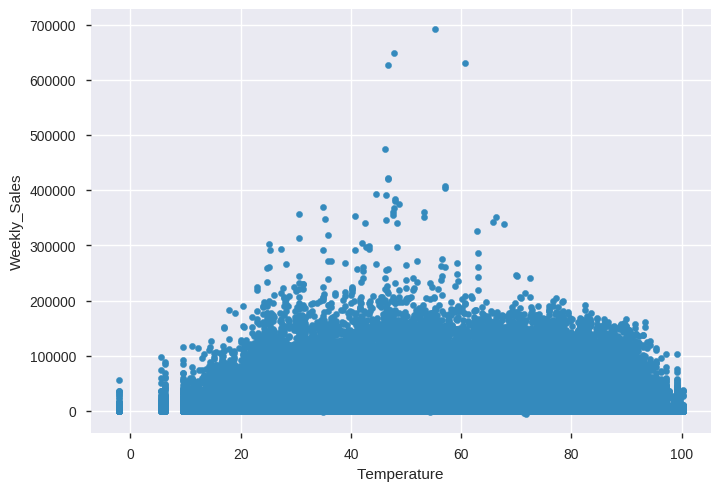

In [32]:
train_set.plot(kind='scatter', x='Temperature', y='Weekly_Sales')

In [66]:
# Categorial temperature 5 bins
train_set['Temp_cat'] = pd.cut(train_set['Temperature'], bins=10, right=True)
train_set.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Temp_cat
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,"(38.82, 49.04]"
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,"(28.6, 38.82]"
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,"(38.82, 49.04]"
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,"(38.82, 49.04]"
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,"(38.82, 49.04]"


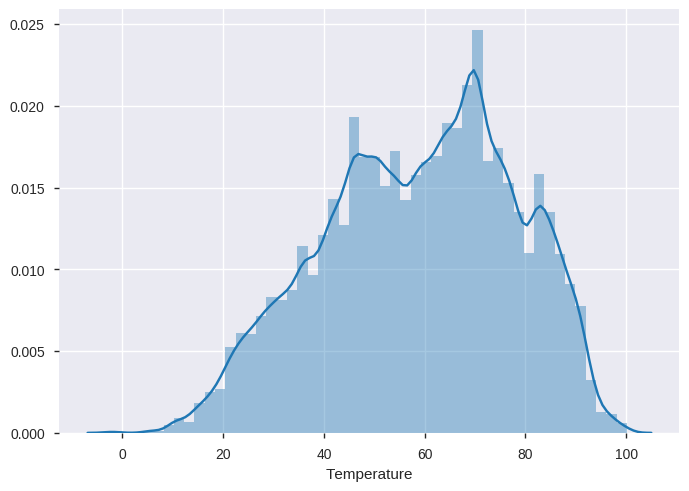

In [62]:
sns.distplot(train_set['Temperature'])

Text(0.5, 0, 'Temperature °F')

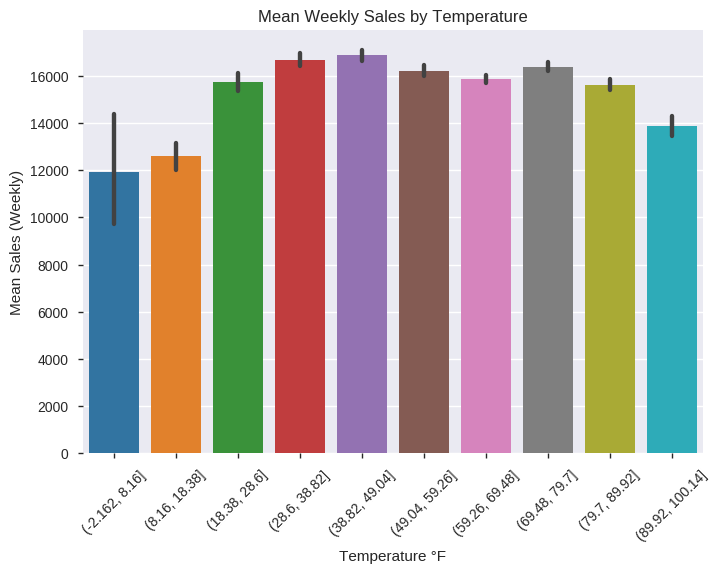

In [67]:
ax = sns.barplot(data=train_set, x='Temp_cat', y='Weekly_Sales')
ax.tick_params(axis='x', rotation=45)
ax.set_title("Mean Weekly Sales by Temperature")
ax.set_ylabel("Mean Sales (Weekly)")
ax.set_xlabel("Temperature °F")

Text(0.5, 0, 'Temperature Range °F')

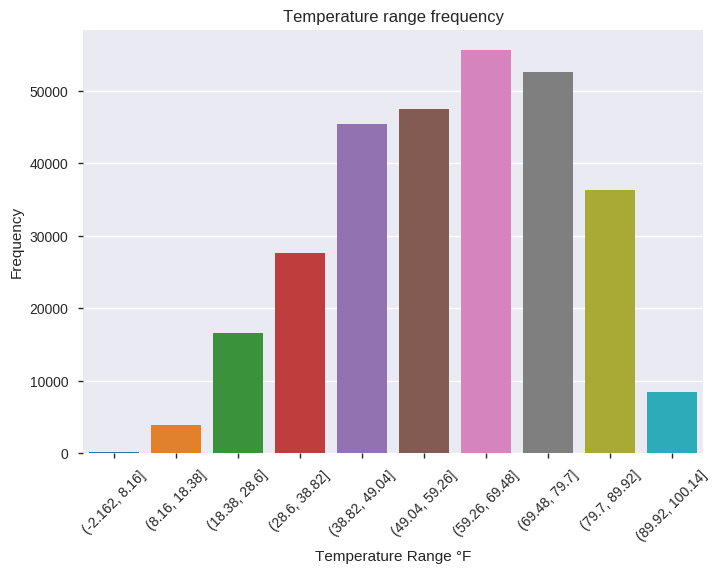

In [70]:
# Count the frequency of the range of temperatures
ax = sns.countplot(data=train_set, x='Temp_cat')
ax.tick_params(axis='x', rotation=45)
ax.set_title("Temperature range frequency")
ax.set_ylabel("Frequency")
ax.set_xlabel("Temperature Range °F")

#### **Fuel_Price**

Cost of fuel in the region

Text(0.5, 0, 'Fuel Price')

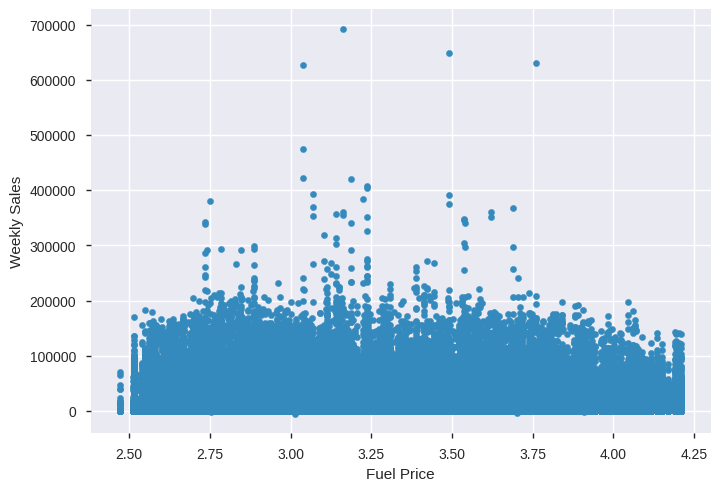

In [73]:
# Scatter plot Fuel Price vs Weekly Sales
ax = train_set.plot(kind='scatter', x='Fuel_Price', y='Weekly_Sales')
ax.set_ylabel("Weekly Sales")
ax.set_xlabel("Fuel Price")

In [74]:
# Correlation
train_set[['Fuel_Price', 'Weekly_Sales']].corr()['Weekly_Sales']

Fuel_Price      0.004089
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

In [75]:
train_set['Fuel_Price'].describe()

count    294132.000000
mean          3.209664
std           0.439060
min           2.472000
25%           2.808000
50%           3.129000
75%           3.595000
max           4.211000
Name: Fuel_Price, dtype: float64

Text(0.5, 0, 'Fuel Price')

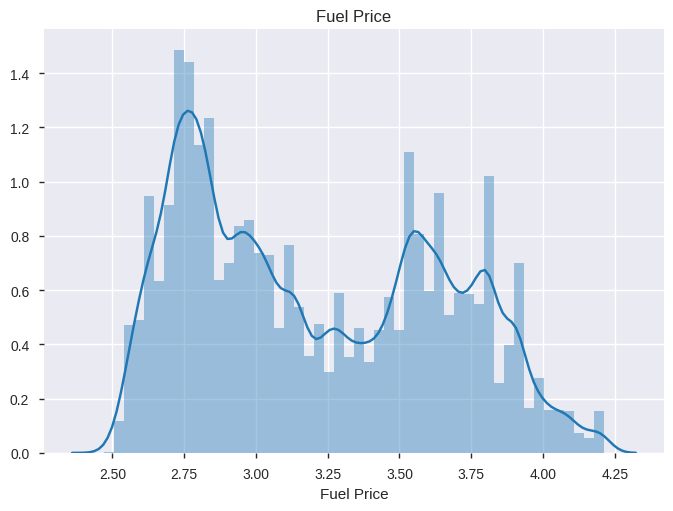

In [77]:
ax = sns.distplot(train_set['Fuel_Price'], label='Fuel Price')
ax.set_title("Fuel Price")
ax.set_xlabel("Fuel Price")

#### **MarkDown**

Anonymized data related to promotional markdowns that Walmart is running.

#### **CPI**

Consumer price indexx

#### **Unemployment**

Unumployment rate